离线强化学习：在智能体不和环境交互的情况下，仅从已经收集好的确定的数据集中，通过强化学习算法得到比较好的策略

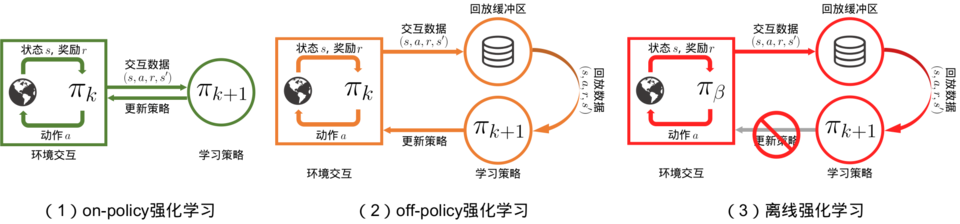

### BCQ 算法

对于离线强化学习算法来说，外推误差是其最需要解决的问题

外推误差，是指由于当前策略可能访问到的状态动作对与从数据集中采样得到的状态动作对的分布不匹配而产生的误差。

为什么在线强化学习算法没有受到外推误差的影响呢？因为对于在线强化学习，即使训练是离线策略的，智能体依然有机会通过与环境交互及时采样到新的数据，从而修正这些误差。但是在离线强化学习中，智能体无法和环境交互。

如何限制外推误差呢？让agent访问与数据集中相似的 $(s, a)$ 数据即可，这一策略称为batch-constrained policy，这样的策略在选择动作时有 3 个目标：

最小化选择的动作与数据集中数据的距离；

采取动作后能到达与离线数据集中状态相似的状态；

最大化函数 $Q$ 。

这种魔改的算法称为BCQ算法，相应的，只需要把Q-learning的更新公式改为：

$$Q(s,a)\leftarrow(1-\alpha)Q(s,a)+\alpha(r+\gamma Q(s^{\prime},\mathrm{argmax}_{a^{\prime}\mathrm{s.t.}(s^{\prime},a^{\prime})\in\mathcal{D}}Q(s^{\prime},a^{\prime})))$$

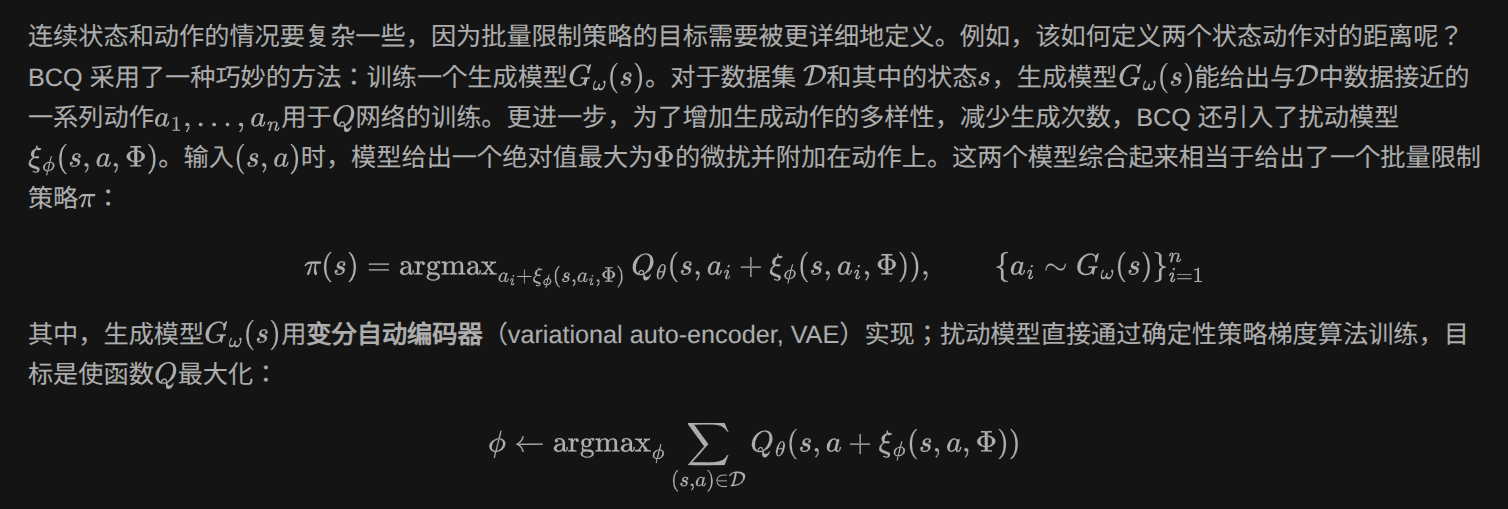

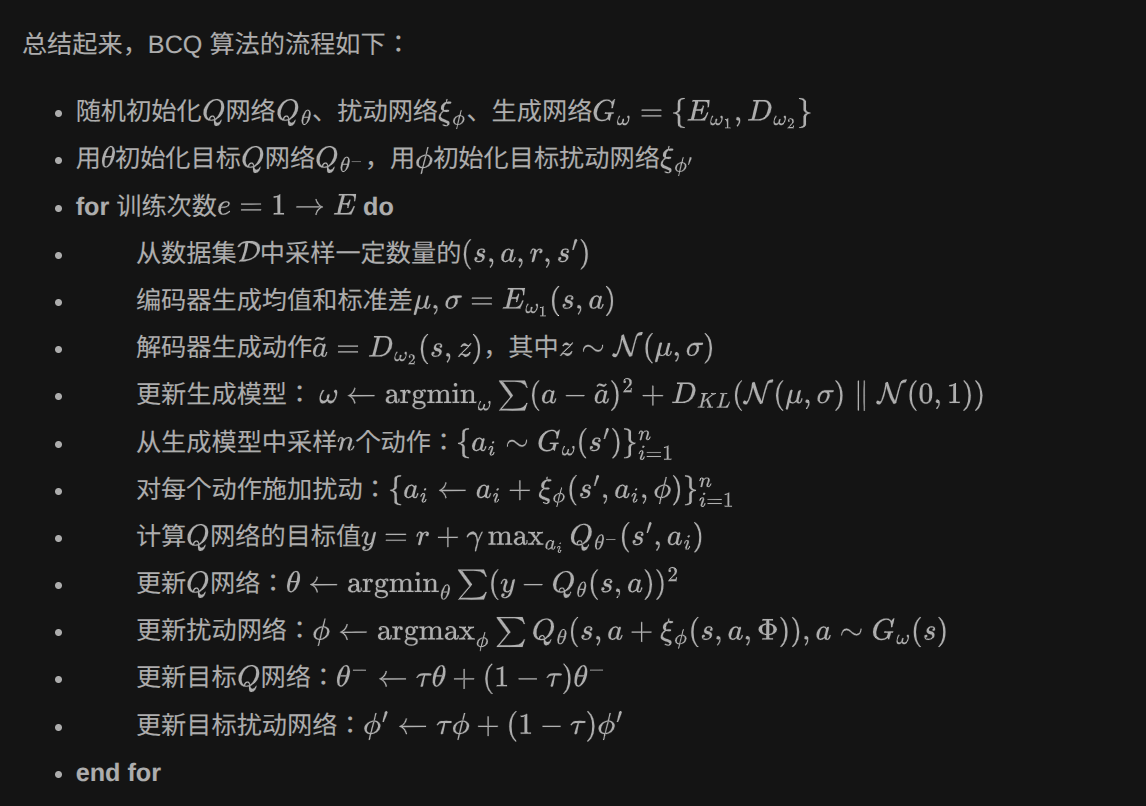

[see code for BCQ here](https://github.com/sfujim/BCQ)

### CQL 算法

类似神经网络中的正则化思想（L2正则化），具体理论推导比较繁琐，关节是修改正常Q-learning的更新函数

$$\hat{Q}^{k+1}\leftarrow\operatorname{argmin}_Q\mathbb{E}_{(s,a)\sim\mathcal{D}}\left[\left(Q(s,a)-\hat{\mathcal{B}}^\pi\hat{Q}^k(s,a)\right)^2\right]$$

到这个形式：

$$\hat{Q}^{k+1}\leftarrow\operatorname{argmin}_Q\beta\cdot\left(\mathbb{E}_{s\sim D,a\sim\mu(a|s)}[Q(s,a)]-\mathbb{E}_{s\sim D,a\sim\hat{\pi}(a|s)}[Q(s,a)]\right)+\frac{1}{2}\mathbb{E}_{(s,a)\sim D}\left[\left(Q(s,a)-\hat{\mathcal{B}}^\pi\hat{Q}^k(s,a)\right)^2\right]$$

其中 $\pi$ 可以被估计为：

$$\pi\approx\max_{\mu}\mathbb{E}_{s\sim\mathcal{D},a\sim\mu(a|s)}[Q(s,a)]$$

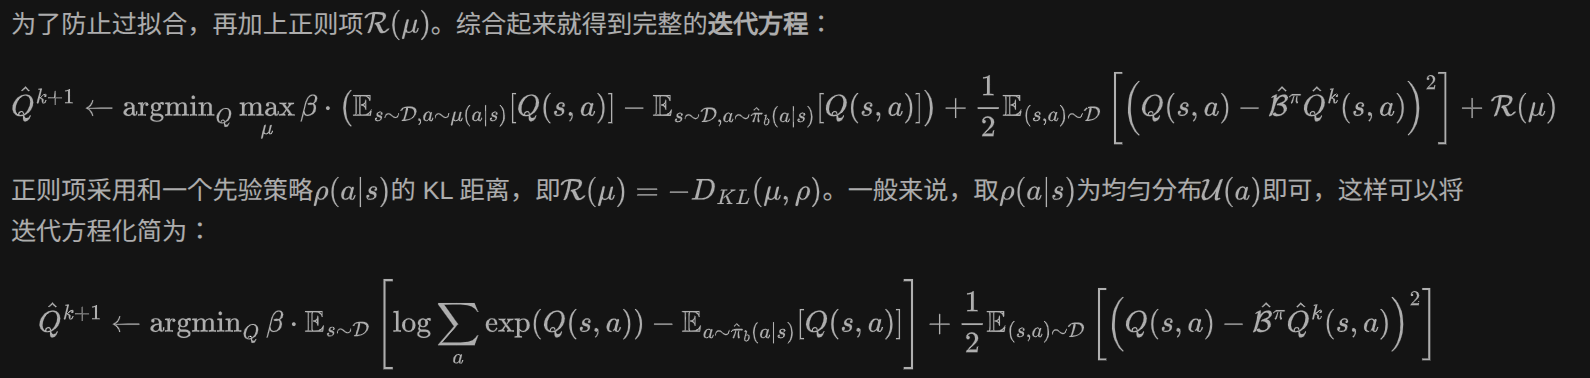

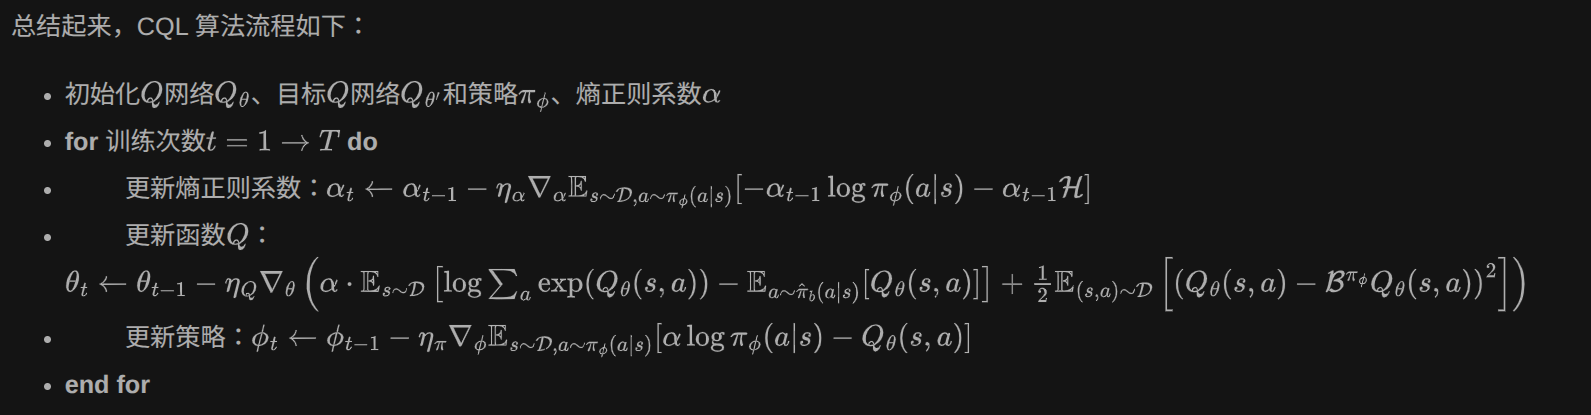

In [2]:
"""这里复制了14的SAC"""

import random
import gym
import numpy as np
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt
import rl_utils

class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))
        dist = Normal(mu, std)
        normal_sample = dist.rsample()  # rsample()是重参数化采样
        log_prob = dist.log_prob(normal_sample)
        action = torch.tanh(normal_sample)
        # 计算tanh_normal分布的对数概率密度
        log_prob = log_prob - torch.log(1 - torch.tanh(action).pow(2) + 1e-7)
        action = action * self.action_bound
        return action, log_prob


class QValueNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)

In [3]:
class SACContinuous:
    ''' 处理连续动作的SAC算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound,
                 actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma,
                 device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim,
                                         action_bound).to(device)  # 策略网络
        self.critic_1 = QValueNetContinuous(state_dim, hidden_dim,
                                            action_dim).to(device)  # 第一个Q网络
        self.critic_2 = QValueNetContinuous(state_dim, hidden_dim,
                                            action_dim).to(device)  # 第二个Q网络
        self.target_critic_1 = QValueNetContinuous(state_dim,
                                                   hidden_dim, action_dim).to(
                                                       device)  # 第一个目标Q网络
        self.target_critic_2 = QValueNetContinuous(state_dim,
                                                   hidden_dim, action_dim).to(
                                                       device)  # 第二个目标Q网络
        # 令目标Q网络的初始参数和Q网络一样
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(),
                                                   lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(),
                                                   lr=critic_lr)
        # 使用alpha的log值,可以使训练结果比较稳定
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
        self.log_alpha.requires_grad = True  # 可以对alpha求梯度
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha],
                                                    lr=alpha_lr)
        self.target_entropy = target_entropy  # 目标熵的大小
        self.gamma = gamma
        self.tau = tau
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action = self.actor(state)[0]
        return [action.item()]

    def calc_target(self, rewards, next_states, dones):  # 计算目标Q值
        next_actions, log_prob = self.actor(next_states)
        entropy = -log_prob
        q1_value = self.target_critic_1(next_states, next_actions)
        q2_value = self.target_critic_2(next_states, next_actions)
        next_value = torch.min(q1_value,
                               q2_value) + self.log_alpha.exp() * entropy
        td_target = rewards + self.gamma * next_value * (1 - dones)
        return td_target

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(),
                                       net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) +
                                    param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        # 和之前章节一样,对倒立摆环境的奖励进行重塑以便训练
        rewards = (rewards + 8.0) / 8.0

        # 更新两个Q网络
        td_target = self.calc_target(rewards, next_states, dones)
        critic_1_loss = torch.mean(
            F.mse_loss(self.critic_1(states, actions), td_target.detach()))
        critic_2_loss = torch.mean(
            F.mse_loss(self.critic_2(states, actions), td_target.detach()))
        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()

        # 更新策略网络
        new_actions, log_prob = self.actor(states)
        entropy = -log_prob
        q1_value = self.critic_1(states, new_actions)
        q2_value = self.critic_2(states, new_actions)
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy -
                                torch.min(q1_value, q2_value))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # 更新alpha值
        alpha_loss = torch.mean(
            (entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)

Iteration 0:   0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_5868/2202922912.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 9: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it, episode=100, return=-181.668]


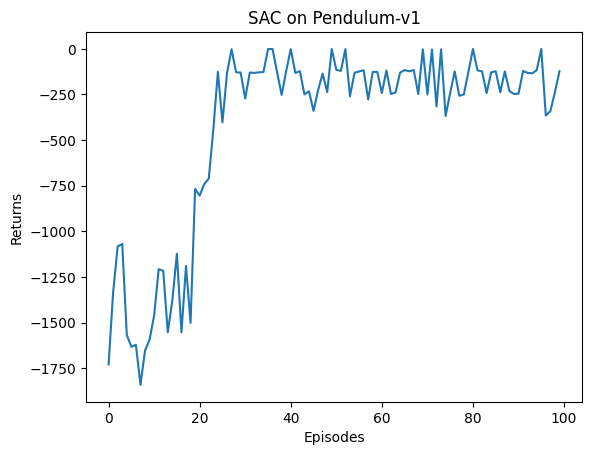

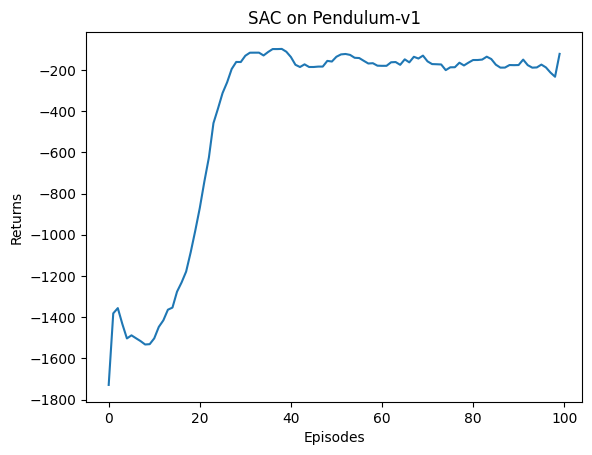

In [4]:
env_name = 'Pendulum-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值
random.seed(0)
np.random.seed(0)
env.reset(seed=0)
torch.manual_seed(0)

if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_
actor_lr = 3e-4
critic_lr = 3e-3
alpha_lr = 3e-4
num_episodes = 100
hidden_dim = 128
gamma = 0.99
tau = 0.005  # 软更新参数
buffer_size = 100000
minimal_size = 1000
batch_size = 64
target_entropy = -env.action_space.shape[0]
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = SACContinuous(state_dim, hidden_dim, action_dim, action_bound,
                      actor_lr, critic_lr, alpha_lr, target_entropy, tau,
                      gamma, device)

return_list = rl_utils.train_off_policy_agent(env, agent, num_episodes,
                                              replay_buffer, minimal_size,
                                              batch_size)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC on {}'.format(env_name))
plt.show()

In [5]:
""" CQL 在 SAC 的基础上做了修改"""

class CQL:
    ''' CQL算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound,
                 actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma,
                 device, beta, num_random):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim,
                                         action_bound).to(device)
        self.critic_1 = QValueNetContinuous(state_dim, hidden_dim,
                                            action_dim).to(device)
        self.critic_2 = QValueNetContinuous(state_dim, hidden_dim,
                                            action_dim).to(device)
        self.target_critic_1 = QValueNetContinuous(state_dim, hidden_dim,
                                                   action_dim).to(device)
        self.target_critic_2 = QValueNetContinuous(state_dim, hidden_dim,
                                                   action_dim).to(device)
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(),
                                                   lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(),
                                                   lr=critic_lr)
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
        self.log_alpha.requires_grad = True  #对alpha求梯度
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha],
                                                    lr=alpha_lr)
        self.target_entropy = target_entropy  # 目标熵的大小
        self.gamma = gamma
        self.tau = tau

        self.beta = beta  # CQL损失函数中的系数
        self.num_random = num_random  # CQL中的动作采样数

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(device)
        action = self.actor(state)[0]
        return [action.item()]

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(),
                                       net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) +
                                    param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).view(-1, 1).to(device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(device)
        rewards = (rewards + 8.0) / 8.0  # 对倒立摆环境的奖励进行重塑

        next_actions, log_prob = self.actor(next_states)
        entropy = -log_prob
        q1_value = self.target_critic_1(next_states, next_actions)
        q2_value = self.target_critic_2(next_states, next_actions)
        next_value = torch.min(q1_value,
                               q2_value) + self.log_alpha.exp() * entropy
        td_target = rewards + self.gamma * next_value * (1 - dones)
        critic_1_loss = torch.mean(
            F.mse_loss(self.critic_1(states, actions), td_target.detach()))
        critic_2_loss = torch.mean(
            F.mse_loss(self.critic_2(states, actions), td_target.detach()))

        # 以上与SAC相同,以下Q网络更新是CQL的额外部分
        batch_size = states.shape[0]
        random_unif_actions = torch.rand(
            [batch_size * self.num_random, actions.shape[-1]],
            dtype=torch.float).uniform_(-1, 1).to(device)
        random_unif_log_pi = np.log(0.5**next_actions.shape[-1])
        tmp_states = states.unsqueeze(1).repeat(1, self.num_random,
                                                1).view(-1, states.shape[-1])
        tmp_next_states = next_states.unsqueeze(1).repeat(
            1, self.num_random, 1).view(-1, next_states.shape[-1])
        random_curr_actions, random_curr_log_pi = self.actor(tmp_states)
        random_next_actions, random_next_log_pi = self.actor(tmp_next_states)
        q1_unif = self.critic_1(tmp_states, random_unif_actions).view(
            -1, self.num_random, 1)
        q2_unif = self.critic_2(tmp_states, random_unif_actions).view(
            -1, self.num_random, 1)
        q1_curr = self.critic_1(tmp_states, random_curr_actions).view(
            -1, self.num_random, 1)
        q2_curr = self.critic_2(tmp_states, random_curr_actions).view(
            -1, self.num_random, 1)
        q1_next = self.critic_1(tmp_states, random_next_actions).view(
            -1, self.num_random, 1)
        q2_next = self.critic_2(tmp_states, random_next_actions).view(
            -1, self.num_random, 1)
        q1_cat = torch.cat([
            q1_unif - random_unif_log_pi,
            q1_curr - random_curr_log_pi.detach().view(-1, self.num_random, 1),
            q1_next - random_next_log_pi.detach().view(-1, self.num_random, 1)
        ],
                           dim=1)
        q2_cat = torch.cat([
            q2_unif - random_unif_log_pi,
            q2_curr - random_curr_log_pi.detach().view(-1, self.num_random, 1),
            q2_next - random_next_log_pi.detach().view(-1, self.num_random, 1)
        ],
                           dim=1)

        qf1_loss_1 = torch.logsumexp(q1_cat, dim=1).mean()
        qf2_loss_1 = torch.logsumexp(q2_cat, dim=1).mean()
        qf1_loss_2 = self.critic_1(states, actions).mean()
        qf2_loss_2 = self.critic_2(states, actions).mean()
        qf1_loss = critic_1_loss + self.beta * (qf1_loss_1 - qf1_loss_2)
        qf2_loss = critic_2_loss + self.beta * (qf2_loss_1 - qf2_loss_2)

        self.critic_1_optimizer.zero_grad()
        qf1_loss.backward(retain_graph=True)
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.zero_grad()
        qf2_loss.backward(retain_graph=True)
        self.critic_2_optimizer.step()

        # 更新策略网络
        new_actions, log_prob = self.actor(states)
        entropy = -log_prob
        q1_value = self.critic_1(states, new_actions)
        q2_value = self.critic_2(states, new_actions)
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy -
                                torch.min(q1_value, q2_value))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # 更新alpha值
        alpha_loss = torch.mean(
            (entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)

In [6]:
random.seed(0)
np.random.seed(0)
env.reset(seed=0)
torch.manual_seed(0)

beta = 5.0
num_random = 5
num_epochs = 100
num_trains_per_epoch = 500

agent = CQL(state_dim, hidden_dim, action_dim, action_bound, actor_lr,
            critic_lr, alpha_lr, target_entropy, tau, gamma, device, beta,
            num_random)

return_list = []
for i in range(10):
    with tqdm(total=int(num_epochs / 10), desc='Iteration %d' % i) as pbar:
        for i_epoch in range(int(num_epochs / 10)):
            # 此处与环境交互只是为了评估策略,最后作图用,不会用于训练
            epoch_return = 0
            state = env.reset()[0]
            done = False
            steps = 0
            while not done and steps < 200:
                steps += 1
                action = agent.take_action(state)
                next_state, reward, done, _, __ = env.step(action)
                state = next_state
                epoch_return += reward
            return_list.append(epoch_return)

            for _ in range(num_trains_per_epoch):
                b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                transition_dict = {
                    'states': b_s,
                    'actions': b_a,
                    'next_states': b_ns,
                    'rewards': b_r,
                    'dones': b_d
                }
                agent.update(transition_dict)

            if (i_epoch + 1) % 10 == 0:
                pbar.set_postfix({
                    'epoch':
                    '%d' % (num_epochs / 10 * i + i_epoch + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

Iteration 9: 100%|██████████| 10/10 [00:53<00:00,  5.38s/it, epoch=100, return=-214.331]


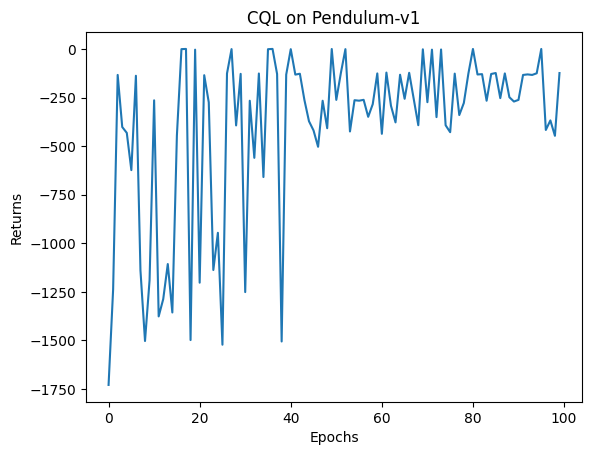

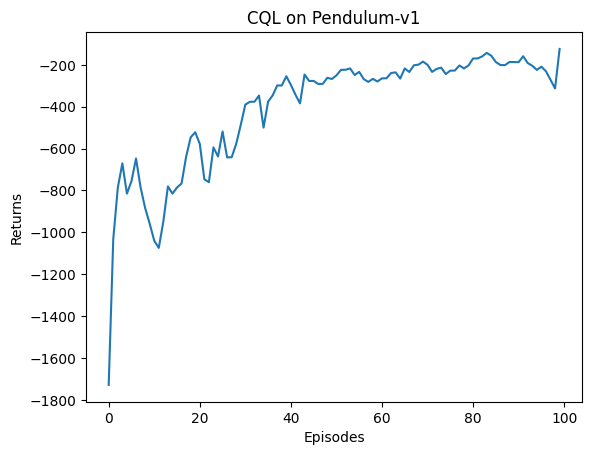

In [7]:
epochs_list = list(range(len(return_list)))
plt.plot(epochs_list, return_list)
plt.xlabel('Epochs')
plt.ylabel('Returns')
plt.title('CQL on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('CQL on {}'.format(env_name))
plt.show()

我来详细解释CQL（Conservative Q-Learning）算法的实现逻辑：

## CQL算法核心思想

CQL是一种**离线强化学习算法**，主要解决离线数据训练中的**Q值过高估计**问题。其核心思想是**保守地估计Q值**——对数据集外的状态-动作对给予较低的Q值，对数据集内的状态-动作对保持准确估计。

## CQL损失函数理论

CQL修改了标准的Q学习目标：

**标准Q学习**：
$$L_{Q} = \mathbb{E}_{(s,a,r,s')\sim \mathcal{D}}[(Q(s,a) - \hat{\mathcal{B}}^\pi Q(s,a))^2]$$

**CQL目标**：
$$L_{CQL} = \underbrace{\mathbb{E}_{s\sim\mathcal{D}, a\sim\mu(a|s)}[Q(s,a)]}_{\text{惩罚项}} - \underbrace{\mathbb{E}_{s\sim\mathcal{D}, a\sim\hat{\pi}(a|s)}[Q(s,a)]}_{\text{恢复项}} + \underbrace{L_{Q}}_{\text{标准项}}$$

## 代码实现详解

### 1. **初始化部分**
```python
self.beta = beta  # CQL损失函数中的系数
self.num_random = num_random  # CQL中的动作采样数
```
- `beta`：控制保守程度的权重系数
- `num_random`：用于估计期望的采样动作数量

### 2. **标准SAC部分**
```python
# 计算TD目标和标准critic损失（与SAC相同）
td_target = rewards + self.gamma * next_value * (1 - dones)
critic_1_loss = torch.mean(F.mse_loss(self.critic_1(states, actions), td_target.detach()))
critic_2_loss = torch.mean(F.mse_loss(self.critic_2(states, actions), td_target.detach()))
```

### 3. **CQL的核心：保守性正则化**

#### a) **生成采样动作**
```python
# 1. 均匀随机动作
random_unif_actions = torch.rand([batch_size * self.num_random, actions.shape[-1]], 
                                dtype=torch.float).uniform_(-1, 1).to(device)
random_unif_log_pi = np.log(0.5**next_actions.shape[-1])  # 均匀分布的log概率

# 2. 当前策略生成的动作
random_curr_actions, random_curr_log_pi = self.actor(tmp_states)

# 3. 下一状态策略生成的动作  
random_next_actions, random_next_log_pi = self.actor(tmp_next_states)
```

#### b) **状态复制**
```python
tmp_states = states.unsqueeze(1).repeat(1, self.num_random, 1).view(-1, states.shape[-1])
```
- 将每个状态复制`num_random`份
- 用于与不同的采样动作配对

#### c) **Q值计算**
```python
# 对三种动作分别计算Q值
q1_unif = self.critic_1(tmp_states, random_unif_actions).view(-1, self.num_random, 1)
q1_curr = self.critic_1(tmp_states, random_curr_actions).view(-1, self.num_random, 1)  
q1_next = self.critic_1(tmp_states, random_next_actions).view(-1, self.num_random, 1)
```

#### d) **重要性加权**
```python
q1_cat = torch.cat([
    q1_unif - random_unif_log_pi,                                           # 均匀采样动作
    q1_curr - random_curr_log_pi.detach().view(-1, self.num_random, 1),    # 当前策略动作
    q1_next - random_next_log_pi.detach().view(-1, self.num_random, 1)     # 下一状态策略动作
], dim=1)
```
**关键理解**：`Q(s,a) - log π(a|s)` 实现了重要性采样，用于估计期望值。

#### e) **CQL损失计算**
```python
qf1_loss_1 = torch.logsumexp(q1_cat, dim=1).mean()  # log∑exp近似max操作
qf1_loss_2 = self.critic_1(states, actions).mean()   # 数据集内Q值的平均

qf1_loss = critic_1_loss + self.beta * (qf1_loss_1 - qf1_loss_2)
```

**数学解释**：
- `qf1_loss_1`：对采样动作Q值的**上界估计**（惩罚项）
- `qf1_loss_2`：对数据集动作Q值的**平均值**（恢复项）
- `beta * (qf1_loss_1 - qf1_loss_2)`：**保守性正则化项**

## CQL的工作机制

### 1. **保守性体现**
- **惩罚**数据集外动作的高Q值
- **保持**数据集内动作的准确Q值
- 通过`beta`控制保守程度

### 2. **重要性采样**
```python
q1_cat = [Q(s,a) - log π(a|s) for different action distributions]
```
这实现了对期望 $\mathbb{E}_{a\sim\pi}[Q(s,a)]$ 的无偏估计。

### 3. **LogSumExp技巧**
```python
torch.logsumexp(q1_cat, dim=1)
```
- 数值稳定地计算 $\log \sum_i \exp(x_i)$
- 近似 $\max_i x_i$，用于上界估计

## 与SAC的区别

| 方面 | SAC | CQL |
|------|-----|-----|
| 训练数据 | 在线采集 | 离线数据集 |
| Q值估计 | 标准TD学习 | 保守性正则化 |
| 动作选择 | 当前策略 | 受数据集约束 |
| 目标 | 最大化回报 | 保守地最大化回报 |

## 训练流程特点

```python
# 关键：只用离线数据训练，不与环境交互收集数据
for _ in range(num_trains_per_epoch):
    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)  # 从固定数据集采样
    agent.update(transition_dict)
```

CQL通过这种设计，能够在纯离线设置下训练出安全、保守但有效的策略，避免了离线强化学习中常见的分布偏移和Q值过估计问题。

Similar code found with 2 license types

这个操作是CQL算法的核心，我来详细解释为什么要这样做：

## 理论背景：重要性采样与期望估计

### 1. **CQL要解决的问题**
CQL需要估计这个期望值：
$$\mathbb{E}_{s\sim\mathcal{D}, a\sim\mu(a|s)}[Q(s,a)]$$

但问题是：我们无法直接从所有可能的分布 $\mu(a|s)$ 中采样，因为有无限多种可能的分布。

### 2. **重要性采样的数学原理**
对于任意两个分布 $p(x)$ 和 $q(x)$，有：
$$\mathbb{E}_{x \sim p}[f(x)] = \mathbb{E}_{x \sim q}\left[\frac{p(x)}{q(x)} f(x)\right]$$

应用到CQL中：
$$\mathbb{E}_{a \sim \mu}[Q(s,a)] = \mathbb{E}_{a \sim \pi}\left[\frac{\mu(a|s)}{\pi(a|s)} Q(s,a)\right]$$

取对数：
$$\log\left(\frac{\mu(a|s)}{\pi(a|s)} Q(s,a)\right) = \log Q(s,a) + \log \mu(a|s) - \log \pi(a|s)$$

## 为什么选择这三种分布？

### 1. **均匀分布（random_unif）**
```python
q1_unif - random_unif_log_pi  # Q(s,a) - log μ_unif(a|s)
```
- **作用**：覆盖整个动作空间，确保不遗漏任何区域
- **log概率**：$\log(0.5^d)$ 其中d是动作维度
- **意义**：代表"无知"的基线分布

### 2. **当前策略分布（random_curr）**
```python
q1_curr - random_curr_log_pi  # Q(s,a) - log π_curr(a|s)
```
- **作用**：考虑当前策略可能选择的动作
- **意义**：确保CQL不会过度惩罚当前策略认为合理的动作

### 3. **下一状态策略分布（random_next）**
```python
q1_next - random_next_log_pi  # Q(s,a) - log π_next(a|s)
```
- **作用**：考虑在下一状态下策略的选择倾向
- **意义**：增加时序相关性，考虑策略的前瞻性

## LogSumExp的巧妙用法

### 数学转换
```python
torch.logsumexp(q1_cat, dim=1)
```

这实际上在计算：
$$\log \sum_{i} \exp(Q(s,a_i) - \log \pi_i(a_i|s))$$

展开后：
$$\log \sum_{i} \frac{Q(s,a_i)}{\pi_i(a_i|s)}$$

这正是多个重要性采样估计的**软最大值**！

## 为什么要拼接（cat）？

### 1. **综合多种采样策略**
```python
q1_cat = torch.cat([q1_unif, q1_curr, q1_next], dim=1)
# 形状：[batch_size, 3*num_random, 1]
```

这样做的效果是：
- 每个状态对应 `3*num_random` 个不同的动作-Q值对
- 涵盖了三种不同的采样策略
- 提供了对Q值上界的更全面估计

### 2. **避免分布偏差**
如果只用一种分布采样，可能会：
- **只用均匀分布**：忽略策略的倾向性
- **只用当前策略**：可能陷入局部最优
- **只用下一状态策略**：缺乏全局视野

### 3. **数值稳定性**
通过组合多种分布：
- 减少单一分布带来的方差
- 提高期望估计的稳定性
- 避免极端值的影响

## 完整的数学解释

最终的损失项：
```python
qf1_loss_1 = torch.logsumexp(q1_cat, dim=1).mean()
```

近似计算：
$$\mathbb{E}_s\left[\log \sum_{i=1}^{3N} \exp(Q(s,a_i) - \log \pi_i(a_i|s))\right]$$

这个值代表：
- 对所有可能动作Q值的**保守上界估计**
- 通过重要性采样修正的**期望Q值**
- 用于惩罚数据集外动作的高Q值

## 实际效果

通过这种设计，CQL能够：

1. **全面覆盖动作空间**：通过均匀分布
2. **保持策略一致性**：通过当前和下一状态策略
3. **数值稳定**：通过LogSumExp和多分布组合
4. **保守估计**：通过上界惩罚机制

这正是CQL能够在离线强化学习中避免Q值过估计，同时保持策略有效性的关键所在。

上面是claude对CQL的解释，这里还要补充一点：此处重要性采样并不完整，缺了一个分子项 $\mu(a|s)$ ，没有显式写出的原因是我们认为这里它可以作为常数，不影响梯度，因此写出来也没用 